In [ ]:
#Install required
!pip install tensorflow
!pip install keras-flops

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.17.1
Pandas Version: 2.2.2
Numpy Version: 1.26.4
System Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [ ]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Correlation

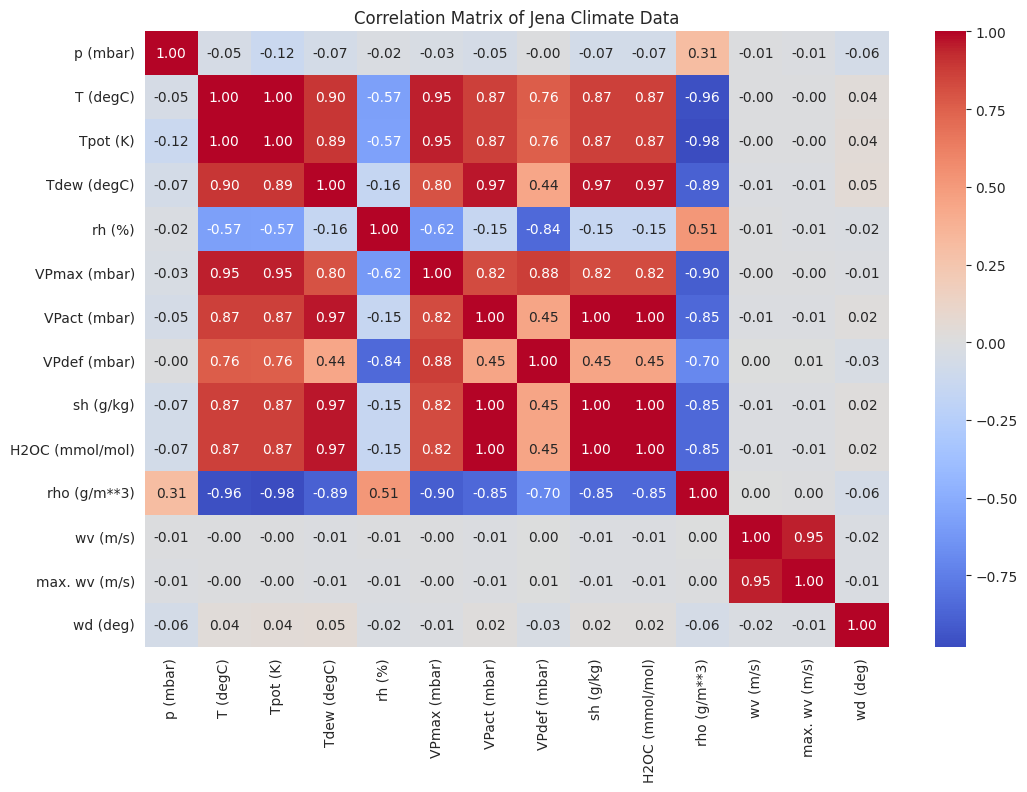

In [ ]:

df_numeric = df.drop(columns=['Date Time'])
# Tính ma trận tương quan
correlation_matrix = df_numeric.corr()

# Vẽ heatmap tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Jena Climate Data')
plt.show()


## Extract Feature Importance


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

 #df = pd.read_csv(csv_path)
 #df = df.drop(columns=['Date Time'])

# Prepare the feature matrix and target vector
X = df.drop(columns=['p (mbar)'])
y = df['p (mbar)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

num_features = len(feature_importance_df)  # Number of features in DataFrame
colors = sns.color_palette("deep", num_features)
palette = dict(zip(feature_importance_df['Feature'], colors))

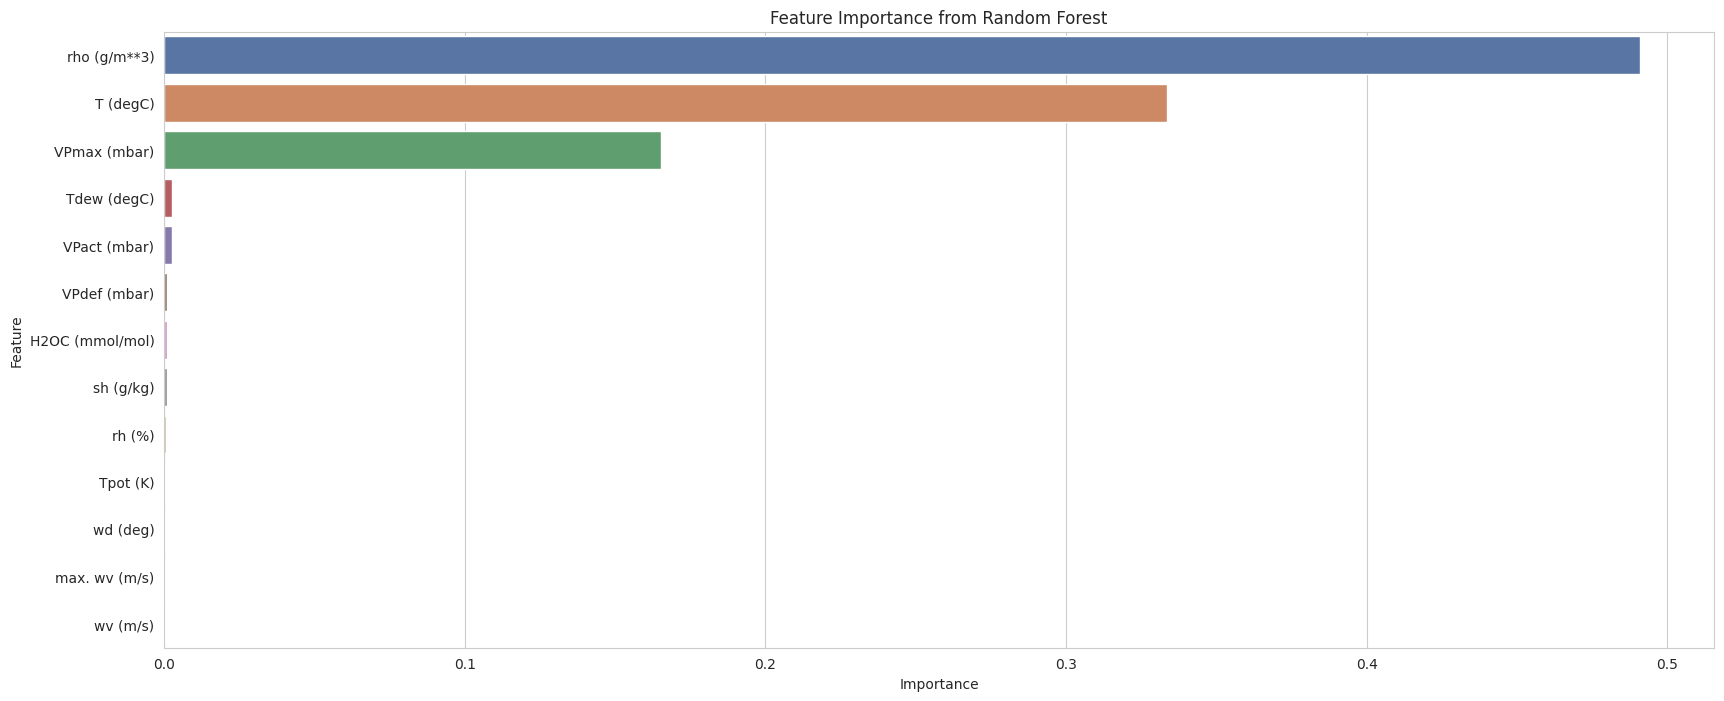

In [ ]:
# Plot the feature importances
plt.figure(figsize=(20, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', dodge=False, palette=palette, legend=False)
plt.title('Feature Importance from Random Forest')
plt.show()

###Decide predict p according 3 highest features

## Normalize

,p (mbar),rho (g/m**3),T (degC),VPmax (mbar)
Date Time,,,,
01.01.2009 00:10:00,0.874230,2.293606,-2.074013,-1.323974
01.01.2009 00:20:00,0.880212,2.344887,-2.120313,-1.336896
01.01.2009 00:30:00,0.875426,2.355894,-2.132184,-1.339480
01.01.2009 00:40:00,0.873033,2.329628,-2.108441,-1.333019
01.01.2009 00:50:00,0.873033,2.324875,-2.103692,-1.331727


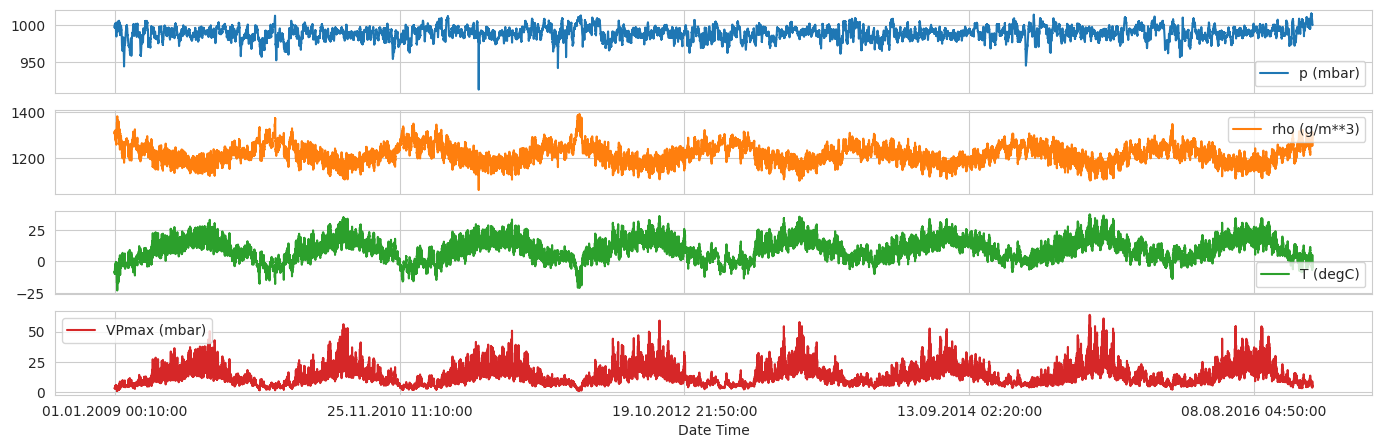

In [ ]:
features_considered = ['p (mbar)', 'rho (g/m**3)', 'T (degC)', 'VPmax (mbar)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

features.plot(subplots=True)

# normalize the whole dataset
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

# print(len(dataset))
# print(dataset.shape)
# print(int(len(dataset)*0.7)-720)

## Outliers

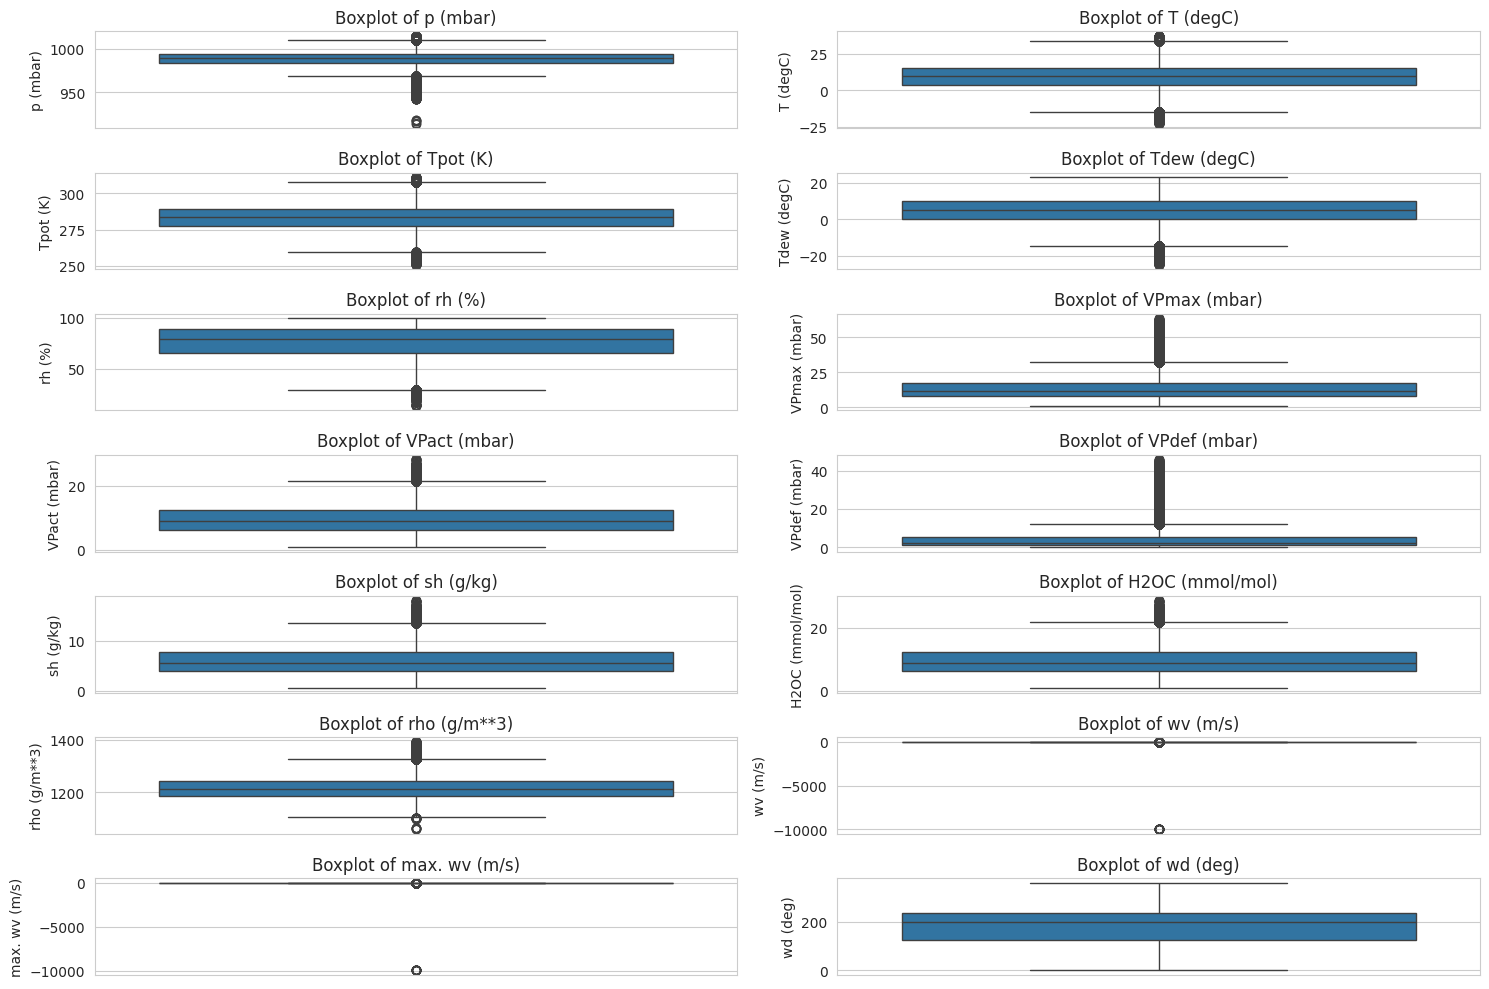

Number of outliers detected using Z-scores: 15460
        p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
721       997.61    -12.93    260.41       -15.24    82.6          2.25   
722       997.62    -13.06    260.28       -15.33    82.9          2.23   
723       997.60    -13.14    260.20       -15.35    83.3          2.21   
724       997.62    -13.24    260.10       -15.43    83.4          2.19   
725       997.71    -13.34    259.99       -15.46    83.9          2.18   
...          ...       ...       ...          ...     ...           ...   
420191   1014.63      3.45    275.47         2.27    91.9          7.83   
420192   1014.57      3.69    275.71         2.43    91.4          7.96   
420193   1014.48      3.77    275.79         2.32    90.2          8.00   
420194   1014.43      3.84    275.87         2.28    89.5          8.04   
420195   1014.42      3.79    275.82         2.20    89.3          8.02   

        VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

df = pd.read_csv(csv_path)
df = df.drop(columns=['Date Time'])

# List of numerical columns
numerical_columns = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

# Plot boxplots for numerical columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(7, 2, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# Calculate Z-scores for numerical columns
z_scores = df[numerical_columns].apply(zscore)

# Identify outliers (z-score > 3 or z-score < -3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers detected using Z-scores: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = df[outliers]
print(outliers_data)

# Calculate IQR for numerical columns
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers detected using IQR: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = df[outliers]
print(outliers_data)

In [ ]:
outliers_zscore = (z_scores.abs() > 3).any(axis=1)
outliers_iqr = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

outliers_combined = outliers_zscore | outliers_iqr
df_cleaned = df[~outliers_combined]

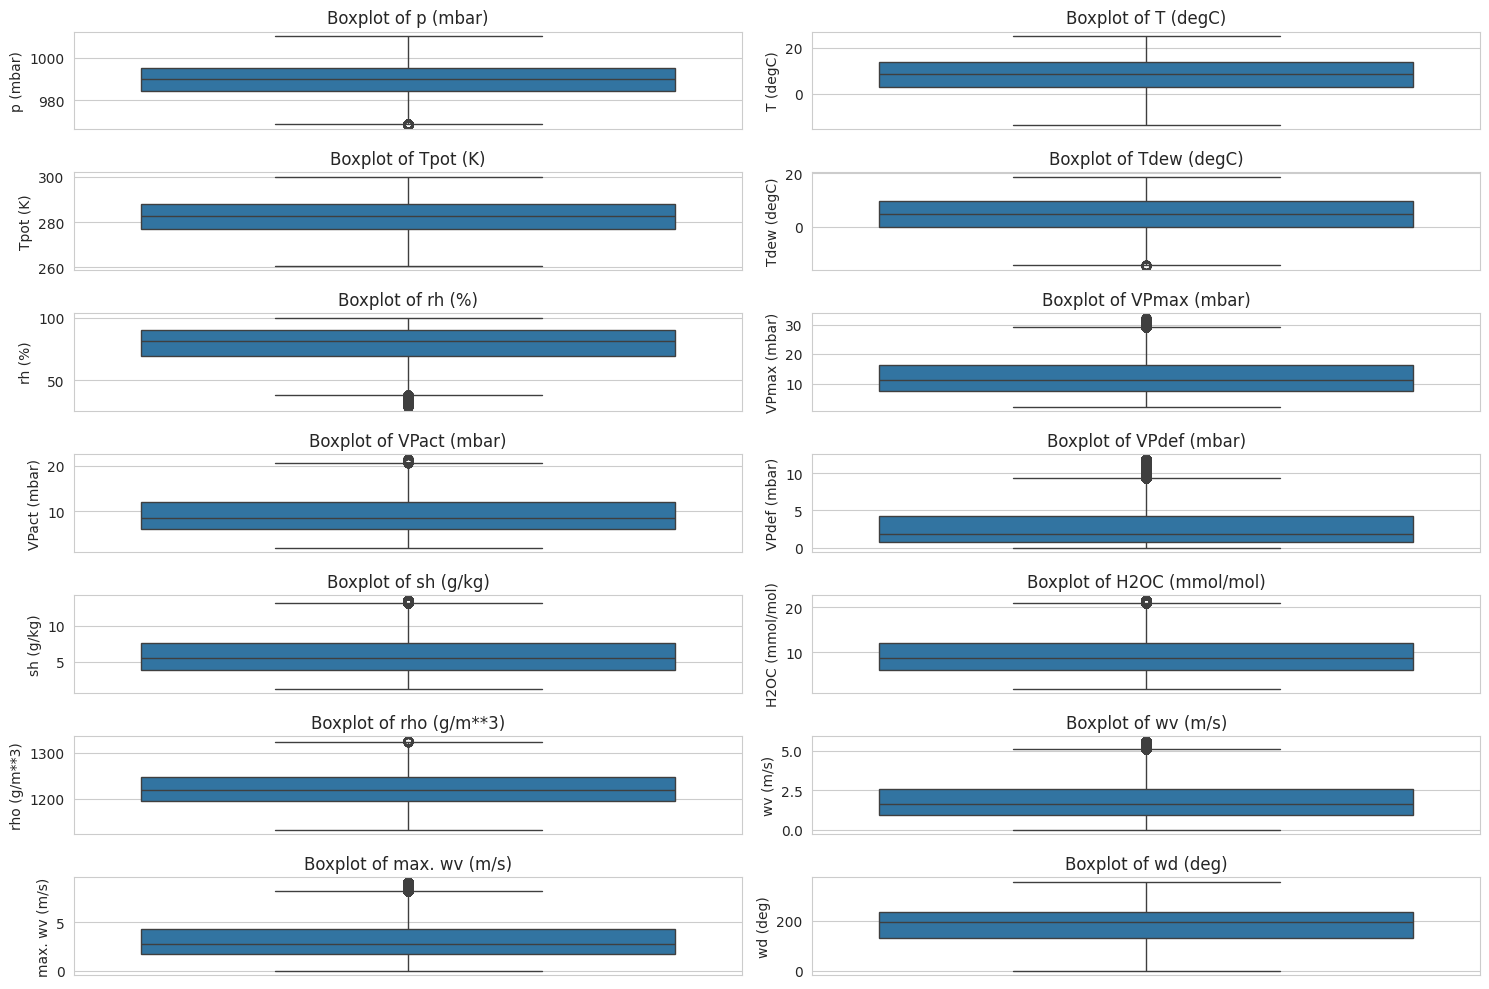

Number of outliers detected using Z-scores: 6599
        p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
945       991.62    -12.05    261.74       -14.46   82.10          2.42   
2523      975.72      4.83    279.95        -0.39   68.82          8.62   
2527      975.63      4.82    279.94        -0.51   68.29          8.62   
2528      975.68      4.63    279.76        -0.62   68.59          8.51   
2540      973.62      3.28    278.57        -0.43   76.50          7.74   
...          ...       ...       ...          ...     ...           ...   
419607    995.59      7.62    281.13         3.62   75.70         10.46   
419699    997.73      8.96    282.30         5.34   78.00         11.46   
419752    995.81      9.70    283.20         5.71   76.10         12.05   
419895   1005.95      6.03    278.72         0.60   68.03          9.38   
419913   1006.89      6.45    279.06         1.23   69.20          9.65   

        VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2O

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# List of numerical columns
numerical_columns = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

# Plot boxplots for numerical columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(7, 2, i)
    sns.boxplot(y=df_cleaned[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# Calculate Z-scores for numerical columns
z_scores = df_cleaned[numerical_columns].apply(zscore)

# Identify outliers (z-score > 3 or z-score < -3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers detected using Z-scores: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = df_cleaned[outliers]
print(outliers_data)

# Calculate IQR for numerical columns
Q1 = df_cleaned[numerical_columns].quantile(0.25)
Q3 = df_cleaned[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR
outliers = ((df_cleaned[numerical_columns] < (Q1 - 1.5 * IQR)) | (df_cleaned[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers detected using IQR: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = df_cleaned[outliers]
print(outliers_data)

## Split Data to Train and Test

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter


# Parameters
window_size = 7  # Define your sequence window size
savgol_window = 3  # Window size for Savitzky-Golay filter (must be odd and >= 3)
savgol_polyorder = 2  # Polynomial order for Savitzky-Golay filter

# Extract all features and target variable
selected_columns = ['rho (g/m**3)', 'T (degC)', 'VPmax (mbar)']

# Split into features (X) and target (y)
X = dataset[:, [features.columns.get_loc(col) for col in selected_columns]]
y = dataset[:, features.columns.get_loc('p (mbar)')]

# X = df[selected_columns].values
# y = df['p (mbar)'].values

# print(int(len(X)))
# print(int(len(y)))

# Define the subset of data
split_index = int(len(X))
X_subset = X[:split_index]
y_subset = y[:split_index]

# Display first 10 rows of features and target variable
print("Features (X):\n", X_subset[:10])
print("\nTarget (y):\n", y_subset[:10])

# Display the shapes of X and y
print("\nShape of X:", X_subset.shape)
print("Shape of y:", y_subset.shape)

# Apply Savitzky-Golay smoothing
X_smooth = savgol_filter(X_subset, savgol_window, savgol_polyorder)
y_smooth = savgol_filter(y_subset, savgol_window, savgol_polyorder)

# Create sequences of 7 time steps for both X (inputs) and y (outputs)
X_sequences = [X_smooth[i:i+window_size] for i in range(len(X_subset) - window_size*2 + 1)]
y_sequences = [y_smooth[i+window_size:i+window_size*2] for i in range(len(y_subset) - window_size*2 + 1)]

# Convert sequences to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data into 70% training and 30% testing
# split_index = int(0.7 * len(X_sequences)) - 720
# X_train = X_sequences[:split_index]
# y_train = y_sequences[:split_index]
# X_test = X_sequences[split_index:]
# y_test = y_sequences[split_index:]

# # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.3, shuffle=True)

# Ensure y is shaped correctly for training (e.g., adding an extra dimension if needed)
y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]

# Print the shapes of training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Features (X):
 [[ 2.29360559 -2.0740129  -1.32397418]
 [ 2.34488743 -2.12031274 -1.33689573]
 [ 2.35589427 -2.1321845  -1.33948004]
 [ 2.32962796 -2.10844099 -1.33301926]
 [ 2.32487501 -2.10369229 -1.33172711]
 [ 2.2963573  -2.07757443 -1.32397418]
 [ 2.24182343 -2.02652589 -1.30976048]
 [ 2.24207359 -2.02652589 -1.30976048]
 [ 2.27909658 -2.06095397 -1.32009771]
 [ 2.34613821 -2.12268709 -1.33689573]]

Target (y):
 [0.87422976 0.88021172 0.87542615 0.87303337 0.87303337 0.87183698
 0.87183698 0.87183698 0.87183698 0.87542615]

Shape of X: (420551, 3)
Shape of y: (420551,)
X_train shape: (294376, 7, 3)
y_train shape: (294376, 7, 1)
X_test shape: (126162, 7, 3)
y_test shape: (126162, 7, 1)


## CNN LSTM

In [ ]:
split_time = 3500
window_size = 7
batch_size = 64
shuffle_buffer_size = 1000

In [ ]:
import tensorflow as tf
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

# Define the Conv1D model for the 7-to-7 regression task
conv1d_model = Sequential([
    # First Conv1D layer
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(window_size, 3), name='conv1d_1'),
    BatchNormalization(name='batch_normalization_1'),
    Dropout(0.2, name='dropout_1'),

    # Second Conv1D layer
    Conv1D(filters=64, kernel_size=3, activation='relu', name='conv1d_2'),
    BatchNormalization(name='batch_normalization_2'),
    Dropout(0.2, name='dropout_2'),

    # Bidirectional LSTM layers
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bidirectional_1'),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2), name='bidirectional_2'),

    # Fully connected layers
    Dense(64, activation='relu', name='dense_1'),
    Dropout(0.2, name='dropout_3'),
    Dense(32, activation='relu', name='dense_2'),
    Dropout(0.2, name='dropout_4'),

    # Output layer for 7 time steps
    Dense(7, name='dense_3')
])

# Print the model summary
conv1d_model.summary()

# Compile the model
conv1d_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 5, 128)              │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 3, 256)              │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 399,239 (1.52 MB)

 Trainable params: 398,855 (1.52 MB)

 Non-trainable params: 384 (1.50 KB)

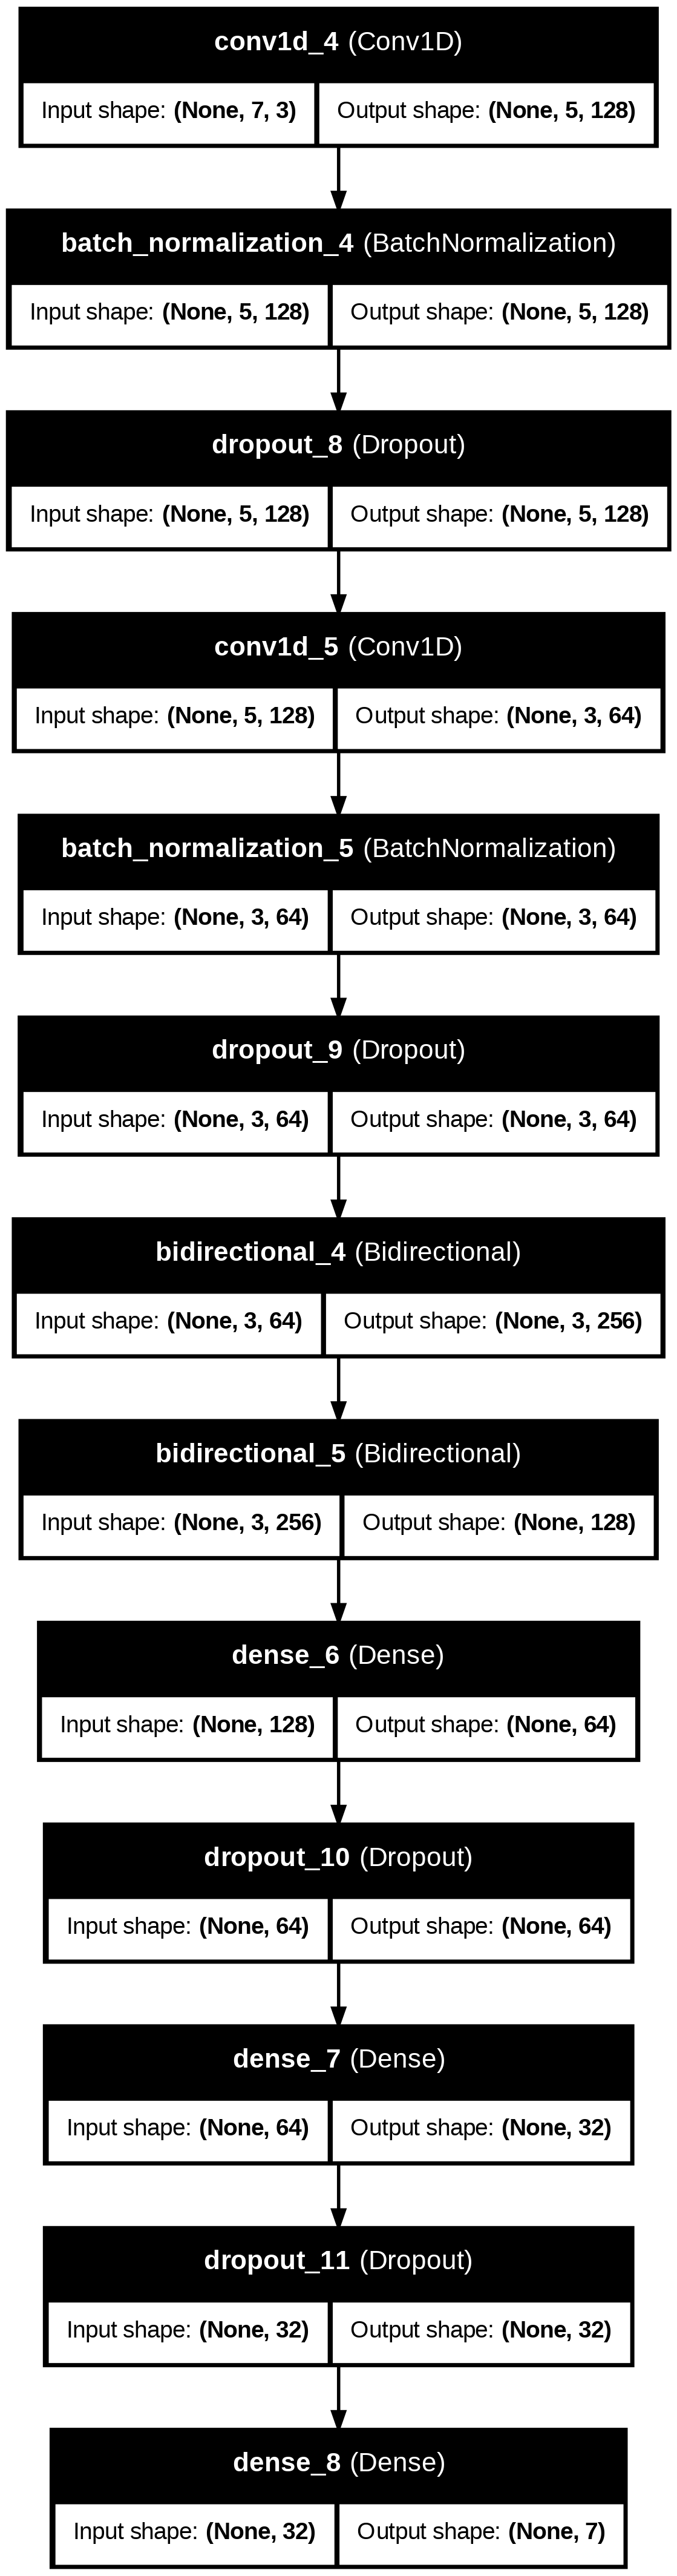

In [ ]:
tf.keras.utils.plot_model(conv1d_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.2,             # Reduce learning rate by a factor of 0.2
    patience=2,             # Wait for 2 epochs before reducing learning rate
    min_lr=0.001             # Minimum learning rate
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Stop training if no improvement for 6 epochs
    restore_best_weights=True # Restore the best model weights
)

# Train the model
conv1d_history = conv1d_model.fit(
    X_train,
    y_train,
    epochs=18,                # Increase max epochs to leverage ReduceLROnPlateau
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr] # Include both callbacks
)

Epoch 1/18
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 231s 27ms/step - loss: 0.1232 - mae: 0.2437 - root_mean_squared_error: 0.3420 - val_loss: 0.0203 - val_mae: 0.1092 - val_root_mean_squared_error: 0.1426 - learning_rate: 0.0010
Epoch 2/18
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 222s 27ms/step - loss: 0.0515 - mae: 0.1675 - root_mean_squared_error: 0.2268 - val_loss: 0.0200 - val_mae: 0.1099 - val_root_mean_squared_error: 0.1415 - learning_rate: 0.0010
Epoch 3/18
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 261s 27ms/step - loss: 0.0468 - mae: 0.1594 - root_mean_squared_error: 0.2164 - val_loss: 0.0169 - val_mae: 0.0999 - val_root_mean_squared_error: 0.1300 - learning_rate: 0.0010
Epoch 4/18
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 215s 26ms/step - loss: 0.0440 - mae: 0.1550 - root_mean_squared_error: 0.2096 - val_loss: 0.0171 - val_mae: 0.1011 - val_root_mean_squared_error: 0.1306 - learning_rate: 0.0010
Epoch 5/18
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 260s 26ms/step - loss: 0.0448 - mae: 0.1556 - root_mean_squared_error: 0.2116 - va

In [ ]:
# Evaluate the model on test data
conv1d_model.evaluate(X_test, y_test)

# Make predictions on new data
predictions = conv1d_model.predict(X_test)

print(y_test.shape)
print(predictions.shape)

3943/3943 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.0153 - mae: 0.0884 - root_mean_squared_error: 0.1238
3943/3943 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step
(126162, 7, 1)
(126162, 7)


(126162, 7, 3)


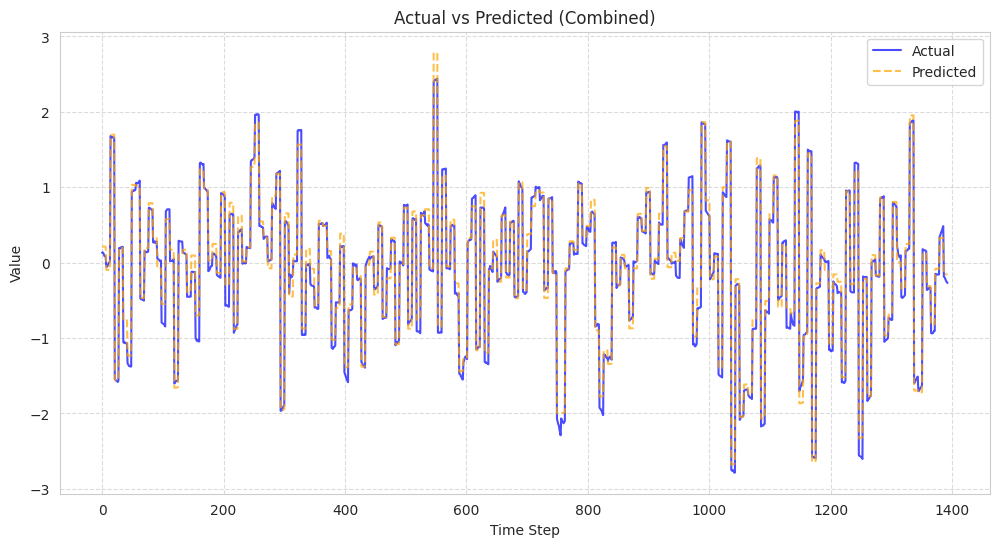


Average RMSE for all samples: 0.0903


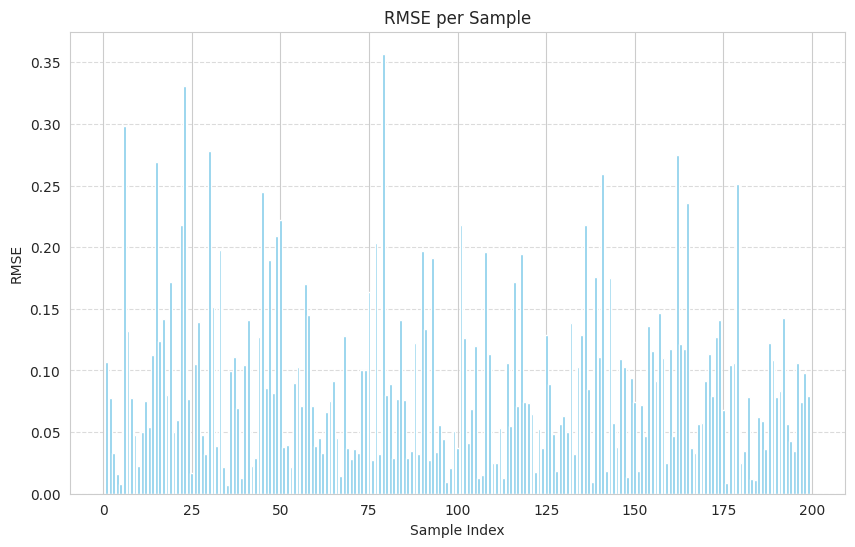

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

print(X_test.shape)

# Reshape y_test to match predictions
y_flat_test = np.squeeze(y_test)
predictions_flat = predictions

# Initialize list to store RMSE for each sample
rmse_per_sample = []

# Combine predictions for all steps into one continuous array
combined_actual_cnn_lstm = []
combined_predicted_cnn_lstm = []

# Visualize the predictions and calculate RMSE for each sample
for i in range(1, 200):  # Visualize the first samples
    sample_idx = i*6  # Example for the first sample
    actual_cnn_lstm = y_flat_test[sample_idx].flatten()  # Flatten to ensure correct shape
    predicted_cnn_lstm = predictions_flat[sample_idx]

    # Calculate RMSE for the current sample
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual_cnn_lstm, predicted_cnn_lstm))
    rmse_per_sample.append(rmse)  # Append RMSE to the list

    # print(f"Sample {sample_idx + 1}: RMSE = {rmse:.4f}")

    time_steps_actual_cnn_lstm = range(sample_idx, sample_idx + len(actual_cnn_lstm))
    time_steps_predicted_cnn_lstm = range(sample_idx, sample_idx + len(predicted_cnn_lstm))

    # Append actual and predicted values to the combined lists
    combined_actual_cnn_lstm.extend(actual_cnn_lstm)
    combined_predicted_cnn_lstm.extend(predicted_cnn_lstm)

# Define a common time range
time_steps = range(len(combined_actual_cnn_lstm))

# Plot the combined actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_steps, combined_actual_cnn_lstm, label="Actual", linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(time_steps, combined_predicted_cnn_lstm, label="Predicted", linestyle='--', linewidth=1.5, color='orange', alpha=0.7)
plt.title("Actual vs Predicted (Combined)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Calculate the average RMSE for all samples
average_rmse = np.mean(rmse_per_sample)
print(f"\nAverage RMSE for all samples: {average_rmse:.4f}")

# Visualize RMSE for all samples
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(rmse_per_sample) + 1), rmse_per_sample, color='skyblue')
plt.title("RMSE per Sample")
plt.xlabel("Sample Index")
plt.ylabel("RMSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## LGBM

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming X_sequences and y_sequences are already prepared
# Flatten the sequences for LightGBM
X_flat_train = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_samples, window_size * num_features)
X_flat_test = X_test.reshape(X_test.shape[0], -1)     # Shape: (n_samples, window_size * num_features)

# Flatten y_train and y_test (LightGBM requires 1D target arrays)
y_flat_train = y_train.reshape(y_train.shape[0], -1)  # Shape: (n_samples, output_steps)
y_flat_test = y_test.reshape(y_test.shape[0], -1)     # Shape: (n_samples, output_steps)

models = []

# Set parameters for the LGBMRegressor model
params = {
    'objective': 'regression',  # Regression objective
    'metric': 'rmse',           # Root Mean Squared Error for evaluation
    'num_leaves': 31,           # Maximum number of leaves in one tree
    'learning_rate': 0.05,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 5           # No maximum depth
}

# Train and evaluate for each output step
for step in range(y_flat_train.shape[1]):
    # Initialize the model
    model = LGBMRegressor(**params)

    # Fit the model
    model.fit(
        X_flat_train,
        y_flat_train[:, step],
        eval_set=[(X_flat_train, y_flat_train[:, step]), (X_flat_test, y_flat_test[:, step])],
        eval_metric="rmse"  # Metric to display during evaluation
    )

    # Make predictions
    predictions = model.predict(X_flat_test)

    models.append(model)  # Store each model in the list

    for i, model in enumerate(models):
        model.booster_.save_model(f'/content/model/lgbm_model_step_{i+1}.txt')

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_flat_test[:, step], predictions))
    mae = mean_absolute_error(y_flat_test[:, step], predictions)

    print(f"Step {step + 1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 1: RMSE = 0.1295, MAE = 0.0929


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 2: RMSE = 0.1298, MAE = 0.0947


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 3: RMSE = 0.1332, MAE = 0.0970


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 4: RMSE = 0.1346, MAE = 0.0986


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.311742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 5: RMSE = 0.1377, MAE = 0.1014


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 6: RMSE = 0.1401, MAE = 0.1035


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 294376, number of used features: 21
[LightGBM] [Info] Start training from score -0.000124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 7: RMSE = 0.1440, MAE = 0.1055


In [ ]:
import lightgbm
models = []
for i in range(7):
    model = lightgbm.Booster(model_file=f'/content/model/lgbm_model_step_{i+1}.txt')
    models.append(model)

(126162, 21)


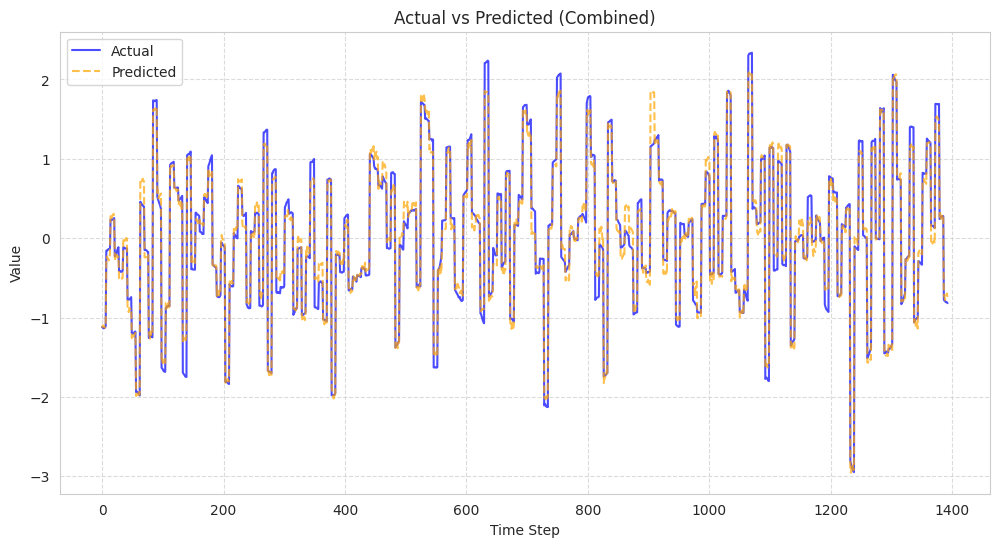


Average RMSE for all samples: 0.1055


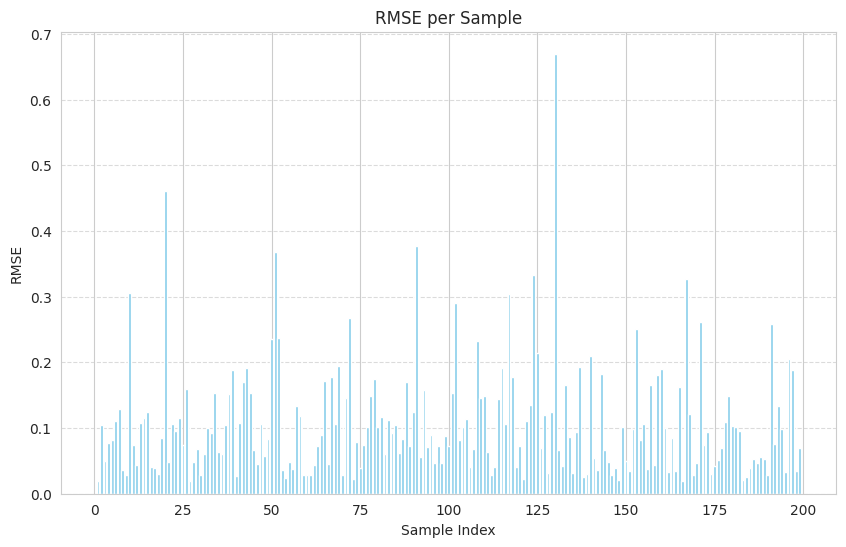

In [ ]:
print(X_flat_test.shape)

# Assume `models` is a list of trained XGBRegressor models for each step
predictions_per_step = []

# Loop through each time step and use the corresponding model for prediction
for step in range(y_flat_test.shape[1]):
    predictions = models[step].predict(X_flat_test)  # Access the specific model for the current step
    predictions_per_step.append(predictions)

# Combine all predictions into a single array
predictions_all = np.array(predictions_per_step).T  # Shape: (n_samples, n_output_steps)

# Initialize list to store RMSE for each sample
rmse_per_sample = []

# Combine predictions for all steps into one continuous array
combined_actual_lgbm = []
combined_predicted_lgbm = []

# Visualize the predictions and calculate RMSE for each sample
for i in range(1, 200):  # Visualize the first samples
    sample_idx = i*6  # Example for the first sample
    actual_lgbm = y_flat_test[sample_idx].flatten()  # Flatten to ensure correct shape
    predicted_lgbm = predictions_all[sample_idx]

    # Calculate RMSE for the current sample
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual_lgbm, predicted_lgbm))
    rmse_per_sample.append(rmse)  # Append RMSE to the list

    # print(f"Sample {sample_idx + 1}: RMSE = {rmse:.4f}")

    time_steps_actual_lgbm = range(sample_idx, sample_idx + len(actual_lgbm))
    time_steps_predicted_lgbm = range(sample_idx, sample_idx + len(predicted_lgbm))

    # Append actual and predicted values to the combined lists
    combined_actual_lgbm.extend(actual_lgbm)
    combined_predicted_lgbm.extend(predicted_lgbm)

# Define a common time range
time_steps = range(len(combined_actual_lgbm))

# Plot the combined actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_steps, combined_actual_lgbm, label="Actual", linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(time_steps, combined_predicted_lgbm, label="Predicted", linestyle='--', linewidth=1.5, color='orange', alpha=0.7)
plt.title("Actual vs Predicted (Combined)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Calculate the average RMSE for all samples
average_rmse = np.mean(rmse_per_sample)
print(f"\nAverage RMSE for all samples: {average_rmse:.4f}")

# Visualize RMSE for all samples
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(rmse_per_sample) + 1), rmse_per_sample, color='skyblue')
plt.title("RMSE per Sample")
plt.xlabel("Sample Index")
plt.ylabel("RMSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## XGB

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming X_sequences and y_sequences are already prepared
# Flatten the sequences for XGBoost
X_flat_train = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_samples, window_size * num_features)
X_flat_test = X_test.reshape(X_test.shape[0], -1)     # Shape: (n_samples, window_size * num_features)

# Flatten y_train and y_test (XGBoost requires 1D target arrays)
y_flat_train = y_train.reshape(y_train.shape[0], -1)  # Shape: (n_samples, output_steps)
y_flat_test = y_test.reshape(y_test.shape[0], -1)     # Shape: (n_samples, output_steps)
models = []

def custom_obj(preds, dtrain):
    labels = dtrain.get_label()
    weight_mse = 0.5  # Weight for MSE
    weight_mae = 0.5  # Weight for MAE

    # Calculate the gradients for MSE and MAE
    mse_grad = 2 * (preds - labels)  # Gradient of MSE
    mse_hess = 2 * np.ones_like(labels)  # Hessian of MSE

    mae_grad = np.sign(preds - labels)  # Gradient of MAE
    mae_hess = np.zeros_like(labels)  # Hessian of MAE (not used in MAE, since it's not differentiable at 0)

    # Combine the gradients and hessians based on the weights
    grad = weight_mse * mse_grad + weight_mae * mae_grad
    hess = weight_mse * mse_hess + weight_mae * mae_hess

    return grad, hess

# Set parameters for the XGBoost model
params = {
    'objective': 'reg:custom',  # Custom regression objective
    'eval_metric': 'rmse',      # Root Mean Squared Error for evaluation
    'max_depth': 7,             # Example depth
    'learning_rate': 0.05,
    'n_estimators': 100,
}

# Train and evaluate for each output step
for step in range(y_flat_train.shape[1]):
    # Create a model for each time step
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8
    )

    # Fit the model
    model.fit(X_flat_train, y_flat_train[:, step])

    # Make predictions
    predictions = model.predict(X_flat_test)

    models.append(model)  # Store each model in the list
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_flat_test[:, step], predictions))
    mae = mean_absolute_error(y_flat_test[:, step], predictions)

    print(f"Step {step + 1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

    # Optional: Save the model for each step
    # model.save_model(f"xgb_model_step_{step + 1}.json")

Step 1: RMSE = 0.1109, MAE = 0.0755
Step 2: RMSE = 0.1119, MAE = 0.0777
Step 3: RMSE = 0.1143, MAE = 0.0801
Step 4: RMSE = 0.1155, MAE = 0.0816
Step 5: RMSE = 0.1192, MAE = 0.0841
Step 6: RMSE = 0.1216, MAE = 0.0863
Step 7: RMSE = 0.1254, MAE = 0.0892


(126162, 21)


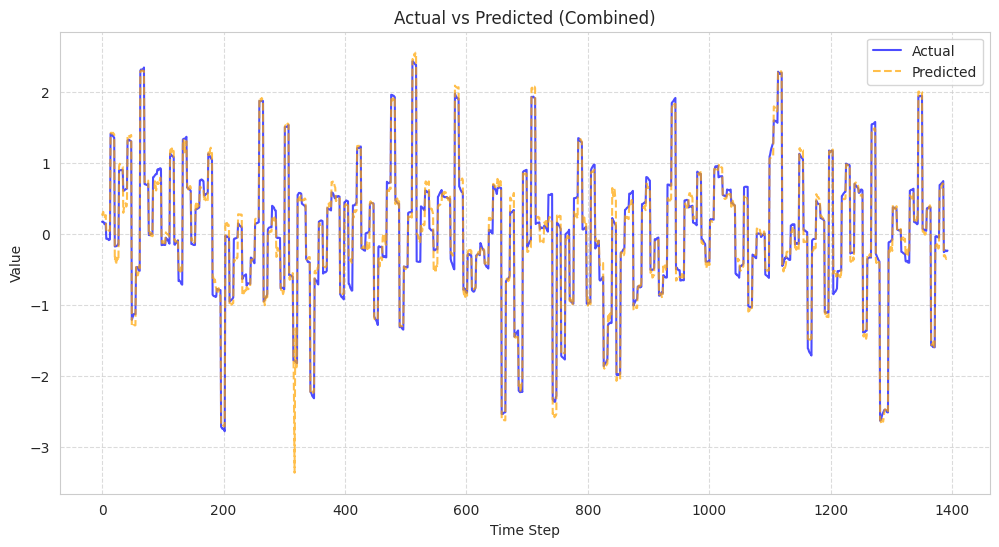


Average RMSE for all samples: 0.1006


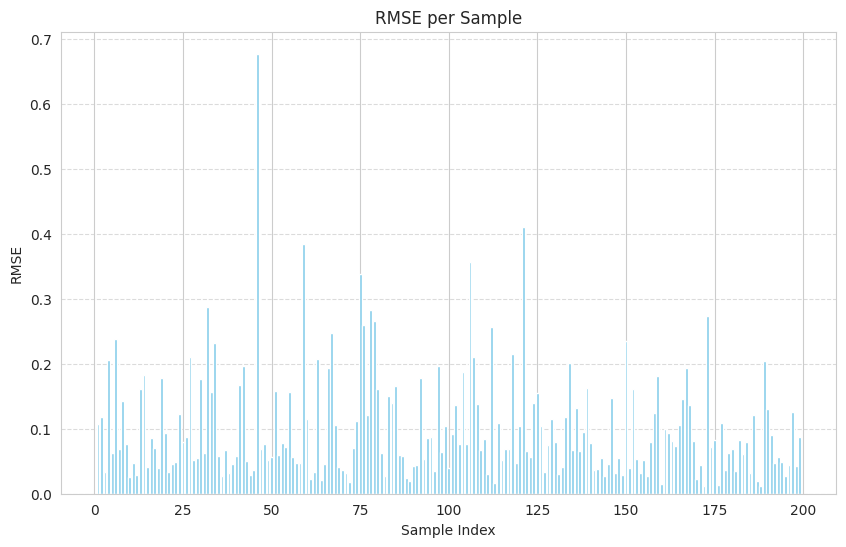

In [ ]:
print(X_flat_test.shape)

# Assume `models` is a list of trained XGBRegressor models for each step
predictions_per_step = []

# Loop through each time step and use the corresponding model for prediction
for step in range(y_flat_test.shape[1]):
    predictions = models[step].predict(X_flat_test)  # Access the specific model for the current step
    predictions_per_step.append(predictions)

# Combine all predictions into a single array
predictions_all = np.array(predictions_per_step).T  # Shape: (n_samples, n_output_steps)

# Initialize list to store RMSE for each sample
rmse_per_sample = []

# Combine predictions for all steps into one continuous array
combined_actual_xgb = []
combined_predicted_xgb = []

# Visualize the predictions and calculate RMSE for each sample
for i in range(1, 200):  # Visualize the first samples
    sample_idx = i*6  # Example for the first sample
    actual_xgb = y_flat_test[sample_idx].flatten()  # Flatten to ensure correct shape
    predicted_xgb = predictions_all[sample_idx]

    # Calculate RMSE for the current sample
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual_xgb, predicted_xgb))
    rmse_per_sample.append(rmse)  # Append RMSE to the list

    # print(f"Sample {sample_idx + 1}: RMSE = {rmse:.4f}")

    time_steps_actual_xgb = range(sample_idx, sample_idx + len(actual_xgb))
    time_steps_predicted_xgb = range(sample_idx, sample_idx + len(predicted_xgb))

    # Append actual and predicted values to the combined lists
    combined_actual_xgb.extend(actual_xgb)
    combined_predicted_xgb.extend(predicted_xgb)

# Define a common time range
time_steps = range(len(combined_actual_xgb))

# Plot the combined actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_steps, combined_actual_xgb, label="Actual", linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(time_steps, combined_predicted_xgb, label="Predicted", linestyle='--', linewidth=1.5, color='orange', alpha=0.7)
plt.title("Actual vs Predicted (Combined)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Calculate the average RMSE for all samples
average_rmse = np.mean(rmse_per_sample)
print(f"\nAverage RMSE for all samples: {average_rmse:.4f}")

# Visualize RMSE for all samples
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(rmse_per_sample) + 1), rmse_per_sample, color='skyblue')
plt.title("RMSE per Sample")
plt.xlabel("Sample Index")
plt.ylabel("RMSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## LSTM


In [ ]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

,rho (g/m**3),p (mbar),T (degC)
Date Time,,,
01.01.2009 00:10:00,2.293606,0.874230,-2.074013
01.01.2009 00:20:00,2.344887,0.880212,-2.120313
01.01.2009 00:30:00,2.355894,0.875426,-2.132184
01.01.2009 00:40:00,2.329628,0.873033,-2.108441
01.01.2009 00:50:00,2.324875,0.873033,-2.103692


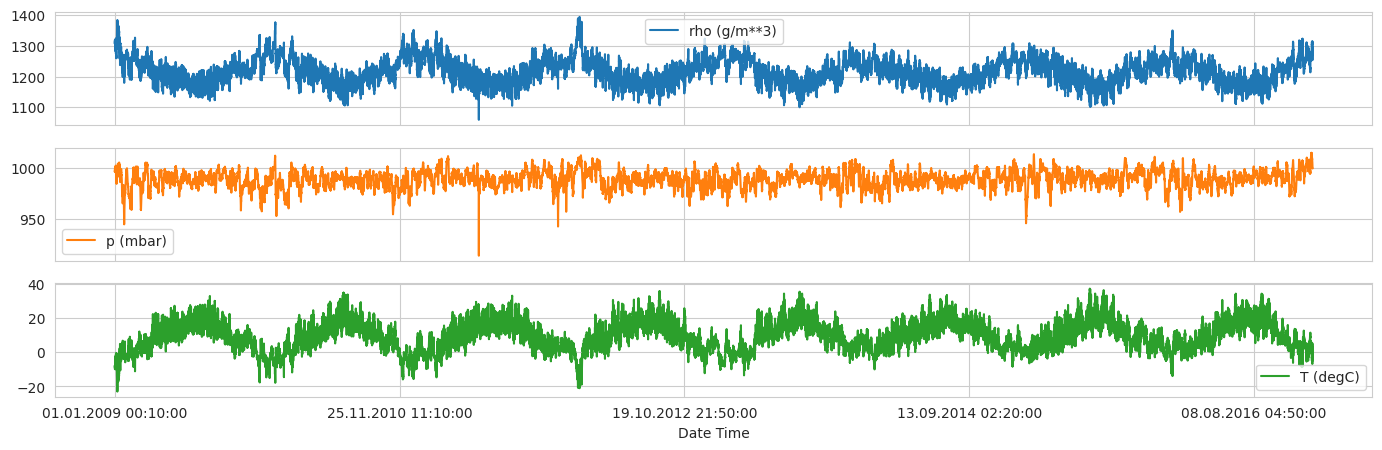

In [ ]:
features_considered = ['rho (g/m**3)', 'p (mbar)','T (degC)']
features = df[features_considered]
features.index = df['Date Time'] ## Need
features.head()

features.plot(subplots=True)

# Normalize the whole dataset
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

In [ ]:
print(len(dataset))
print(dataset.shape)
print(int(len(dataset)*0.7)-720)

420551
(420551, 3)
293665


In [ ]:
#designed to prepare data for machine learning models
# 1. dataset: The input features (independent variables), typically a time-series or multivariate dataset.
# 2. target: The target/output variable(s) that the model is trying to predict.
# 3. start_index: The starting index in the dataset from which data preparation begins.
# 4. end_index: The ending index for slicing the dataset. If None, the function processes until the end of the dataset.
# 5. history_size: The number of past time steps (or data points) to include as input features.
# 6. target_size: The number of future time steps to predict.
# 7. step: The interval between successive time steps in the input sequence (e.g., step=1 means no skipping).
# 8. single_step: A boolean flag indicating whether to predict a single future time step (True) or multiple steps (False).
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size # Adds history_size to start_index to ensure there's enough historical data for the first input sequence
    if end_index is None:
        end_index = len(dataset) - target_size # If end_index is not provided, it is set to allow space for the target predictions (target_size).

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices]) # 1 hàng của data sẽ là gồm 120 ngày vs 3 feature 120x3

        if single_step:
            labels.append(target[i+target_size]) # 1 hàng bao gồm 72 nhiệt độ giãn cách time step nhau
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
### Preparing data for training and testing
past_history = 720
future_target = 72
STEP = 6
## Lấy 720 mẫu nhưng nhảy 6 bước -> còn 120 mẫu thực sự trong data

### x là tập để dự đoán cả 3 features, y chỉ dự đoán 1 features p
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 int(len(dataset)*0.7), past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             int(len(dataset)*0.7), None, past_history,
                                             future_target, STEP)

print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[2].shape),
       'Target pressure to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

print('\n\n\n')

print (x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_val_multi.shape[-2:]),
       'Target pressure to predict : {}'.format(y_val_multi[0].shape),
       sep='\n')

(293665, 120, 3)
(293665, 72)
Single window of past history : (120, 3)
Target pressure to predict : (72,)




(125374, 120, 3)
(125374, 72)
Single window of past history : (120, 3)
Target pressure to predict : (72,)


In [ ]:
## Create a array of data
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
# Building model
inputs = tf.keras.layers.Input(shape=(1, x_train_multi.shape[1], x_train_multi.shape[2]))## Data input với 120 mẫu và tại mỗi điểm có 3 features -> 1 x 120 x3
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.Input(shape=(x_train_multi[0].shape), name='input')) ## Input layer 120x3
multi_step_model.add(tf.keras.layers.LSTM(16, activation = 'tanh', recurrent_activation="sigmoid",
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:],
                                          name='lstm_1')) # Input 120x3 -> 120 cell states và mỗi cell có 3 features vào và đẩy ra ma trận 16x1 -> 120x16
multi_step_model.add(tf.keras.layers.LSTM(32, activation = 'tanh', recurrent_activation="sigmoid", name='lstm_2')) # Chỉ trả về kết quả ở cell cuối là 32
multi_step_model.add(tf.keras.layers.Dense(72, name='dense_1')) # Lớp fully connected 1x72
### Ra 72 giá trị áp suất và vì 1h có 6 giá trị(mỗi 10ph) nên predict đc trong 12h típ theo
# multi_step_model.input.set_shape((1,) + multi_step_model.input.shape[1:])
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 120, 16)             │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 72)                  │           2,376 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,928 (38.78 KB)

 Trainable params: 9,928 (38.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 1
multi_step_model.input.set_shape((batch_size,)+ multi_step_model.input.shape[1:])
print(multi_step_model.summary())
print(multi_step_model.input.shape)

In [ ]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)
    print(multi_step_model.predict(x)[0])

8/8 [==============================] - 2s 20ms/step
(256, 72)
8/8 [==============================] - 0s 20ms/step
[-0.03658089 -0.0757288   0.16723605 -0.16136688 -0.05163277  0.02361542
 -0.14564103 -0.06897197  0.01547557  0.0628711  -0.02183358  0.00209703
  0.01154988 -0.00388872  0.05672685 -0.08721891 -0.06286778 -0.03295422
 -0.08114529  0.03829463 -0.08902915  0.09051084  0.03242443  0.18079071
 -0.04290206 -0.09790673  0.05543472  0.05006903  0.03361617 -0.19412844
  0.02490579 -0.12613374 -0.0262814   0.04824543 -0.05881731 -0.04813295
 -0.10710638 -0.07857438  0.00179169  0.00041237  0.06247719  0.01076699
 -0.03327131  0.12681216 -0.16650172  0.01378713 -0.14342058  0.04041418
  0.0569235   0.00136033  0.09741078  0.03504771 -0.06422656  0.04450271
 -0.02807099 -0.2231484   0.07897924  0.06579441 -0.09525662  0.18855275
  0.07168241 -0.04561208 -0.0028652  -0.08782765 -0.14751393 -0.0456183
  0.0537665   0.00657664  0.13888931  0.01716153 -0.07694051 -0.08818513]


In [ ]:
###Training
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/50
200/200 [==============================] - 75s 329ms/step - loss: 0.4132 - val_loss: 0.2500
Epoch 2/50
200/200 [==============================] - 54s 268ms/step - loss: 0.2022 - val_loss: 0.2192
Epoch 3/50
200/200 [==============================] - 55s 274ms/step - loss: 0.1869 - val_loss: 0.2098
Epoch 4/50
200/200 [==============================] - 49s 247ms/step - loss: 0.1872 - val_loss: 0.1895
Epoch 5/50
200/200 [==============================] - 47s 238ms/step - loss: 0.1639 - val_loss: 0.1831
Epoch 6/50
200/200 [==============================] - 56s 281ms/step - loss: 0.1666 - val_loss: 0.1734
Epoch 7/50
200/200 [==============================] - 56s 278ms/step - loss: 0.1563 - val_loss: 0.1729
Epoch 8/50
200/200 [==============================] - 54s 270ms/step - loss: 0.1405 - val_loss: 0.1619
Epoch 9/50
200/200 [==============================] - 54s 271ms/step - loss: 0.1517 - val_loss: 0.1659
Epoch 10/50
200/200 [==============================] - 48s 243ms/step - l

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(multi_step_model)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [ ]:
## Save the model
import pathlib
tflite_models_dir = pathlib.Path("./lstm_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)


tflite_model_file = tflite_models_dir/"lstm_model.tflite"
tflite_model_file.write_bytes(tflite_model)


44452

In [ ]:
import time
# start_time=time.time()
NO_SAMPLES = 150


### Inference
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()

  # Ensure the input is in the correct dtype (float32)
  input = np.array(input, dtype=np.float32)

  # Set the tensor in the interpreter
  input_tensor[:, :, :] = input # Stores the quantized input in the model’s input tensor



def predict_weather(interpreter,input):

  set_input_tensor(interpreter, input)
  interpreter.invoke() # Executes the model to compute predictions.

  # Get output
  output_details = interpreter.get_output_details()[0]
  output = np.array(interpreter.get_tensor(output_details['index']))  # Copy the tensor data

  return output


##### Change the tflite here (quantized or float model)
interpreter = tf.lite.Interpreter(model_path="/content/lstm_tflite_models/lstm_model.tflite")
interpreter.allocate_tensors()
test_prediction = []
start_time=time.time()
for index in range(NO_SAMPLES):
    # Call predict_weather with the processed input
    test_prediction.append(predict_weather(interpreter, x_val_multi[index]))

end_time=time.time()
duration= end_time-start_time
print(duration)

0.6613423824310303


In [ ]:
### Evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

rmse = []

for index in range(len(test_prediction)):
  actual = y_val_multi[index]
  predicted = test_prediction[index].transpose()
  rmse.append(sqrt(mean_squared_error(actual, predicted)))

print("Average RMSE:",np.average(rmse))
print("Standard Deviation of RMSE:",np.std(rmse))


Average RMSE: 0.22394527425193
Standard Deviation of RMSE: 0.08267591816090862


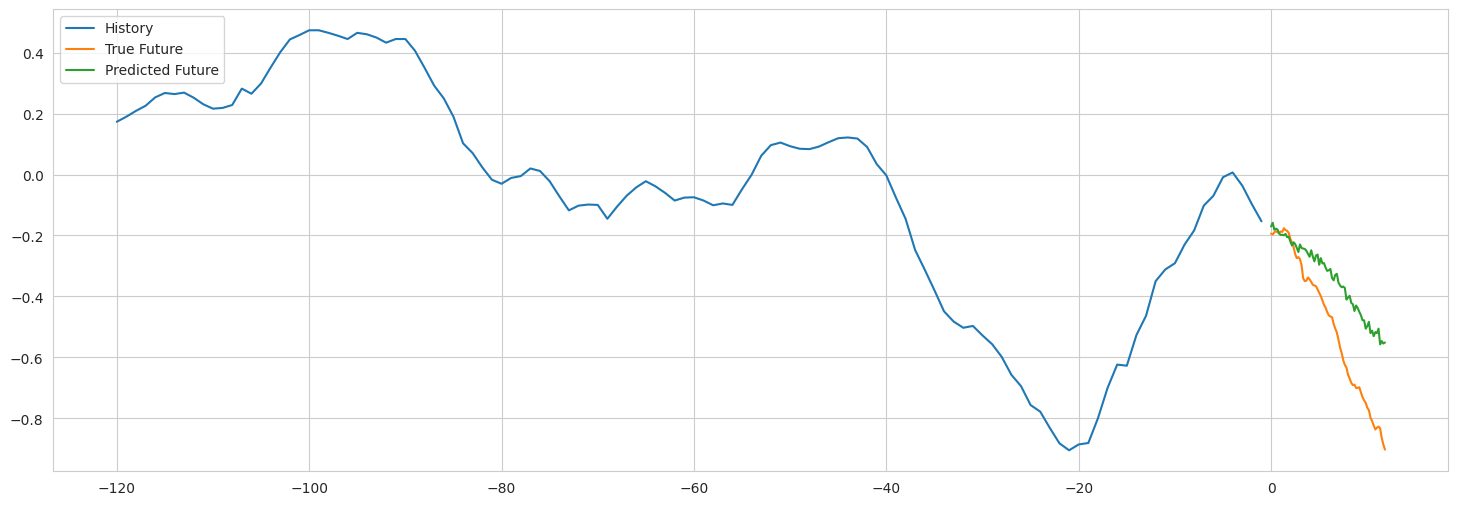

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))


def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history)) # Generates an array of time steps corresponding to the length of the history. This is used as the x-axis for the historical data.
    num_out = len(true_future) # The number of future time steps (length of true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History') # Plot the history
    plt.plot(np.arange(num_out)/STEP, np.array(true_future),
           label='True Future') # Plot the true future
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()


multi_step_plot(x_val_multi[4], y_val_multi[4], test_prediction[4].transpose())

## Predict 2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

df = pd.read_csv(csv_path)
df = df.drop(columns=['Date Time'])

# Prepare the feature matrix and target vector
X = df.drop(columns=['rh (%)'])
y = df['rh (%)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

num_features = len(feature_importance_df)  # Number of features in DataFrame
colors = sns.color_palette("deep", num_features)
palette = dict(zip(feature_importance_df['Feature'], colors))

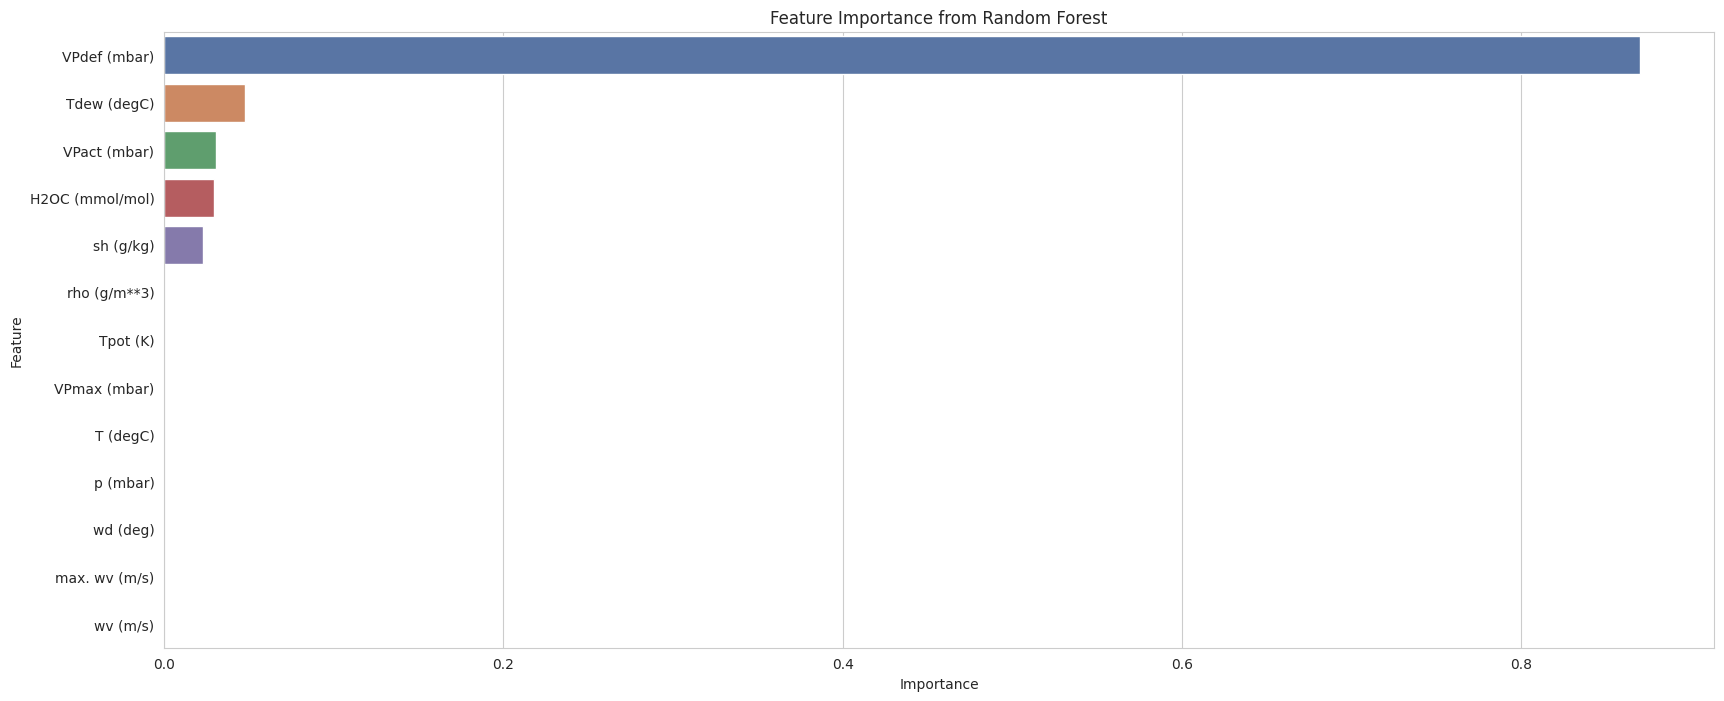

In [ ]:
# Plot the feature importances
plt.figure(figsize=(20, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', dodge=False, palette=palette, legend=False)
plt.title('Feature Importance from Random Forest')
plt.show()